In [1]:
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
from captum.attr import IntegratedGradients
from NegativeClassOptimization.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path
import torch
import torch.nn as nn
import pandas as pd
from captum.attr import IntegratedGradients
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
from tqdm import tqdm

## Finding correct mutants

In [2]:
#get number of mutations from ID
def get_mutations(ID):
    try:
        n_mut = re.search('([0-9])m',ID).group(1)
        return int(n_mut)
    except:
        return np.NaN

In [3]:
def find_ids(ID):
    try:
        first_id = re.match('[A-Z_]*([0-9]+_[0-9]*[a-z])',ID).group(1)
        return first_id
    except:
        return 'unknown'

In [4]:
def prep_mut_df(mut_folder):
    mut_file = pd.read_csv(mut_path / f'{mut_folder}/PooledTempResults_merged.txt', sep=' ')
    mut_file['n_mut'] = mut_file['ID_slide_Variant'].apply(get_mutations)
    mut_file['ID'] = mut_file['ID_slide_Variant'].apply(find_ids)
    return mut_file

In [5]:
# find mutated slides corresponding to slides from test set
def get_org_slide_id(mut_file, wt_path):
    wt_file = pd.read_csv(wt_path, sep='\t')
    wt_test = wt_file[wt_file['y'] == 1] 
    wt_slides = set(wt_test.Slide)
    int_slides = set(mut_file[mut_file['n_mut'] == 0]['Slide']).intersection(wt_slides)
    slide_id = mut_file[mut_file['Slide'].isin(int_slides) & (mut_file['n_mut']==0)][['Slide', 'ID', 'Energy']]
    return slide_id

In [6]:
# in the simulation a mutattion is also a shift in 11 mer, this function finds point mutations without changing the 11mer
def get_mut_patterns(slide):
    ex_slide_list = list(slide)
    mut_patterns = []
    for i in range(11):
        mut_pattern = ex_slide_list[:i] + [f'[^{ex_slide_list[i]}]']
        if i < 10:
            mut_pattern = mut_pattern + ex_slide_list[i+1:]
        mut_patterns.append(((i),''.join(mut_pattern)))
    return mut_patterns

In [7]:
def ig_from_oh(oh_slide,ig,baseline):
    oh_slide = np.array(oh_slide)
    oh_slide = torch.tensor(oh_slide).float()
    attr = ig.attribute(oh_slide, baseline)
    attr = attr.squeeze()
    attr = attr.reshape(11, -1)
    attr = attr.detach().numpy()
    aa_attr = list(map(sum, attr))
    return aa_attr

In [8]:
#experimenting
def mutant_ig(ig,mut_file, slide_id, n_mut=1):
    dfs_list = []
    for slide, ID, Energy, degrees in  slide_id.values:
        mut_patterns = get_mut_patterns(slide) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for i, pattern in mut_patterns:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['degree wt'] = int(degrees[i][1])
            df_pos_mut['posn IG mut'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
            df_pos_mut['posn IG org'] = df_pos_mut['IG org'].apply(lambda x: x[i])
            df_pos_mut['posn delta IG'] =  df_pos_mut['posn IG org'] - df_pos_mut['posn IG mut']
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            dfs_list.append(df_pos_mut)
    return pd.concat(dfs_list)

## Finding best model

In [9]:
#open and closed performances
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)

In [10]:
#choose the best model in terms of closed performance
def get_best_model_seed_split(df, train_task, test_task, ag, metric):
    task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
    best_row = task_df[task_df['acc'] == task_df['acc'].max()]
    seed_id = best_row['seed_id'].values[0]
    split_id = best_row['split_id'].values[0]
    return seed_id , split_id

In [11]:
tasks = ['ONE_VS_NINE', 'HIGH_VS_95LOW', 'HIGH_VS_LOOSER']
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}

In [150]:
perf_df.head()

,acc,recall,precision,f1,train_task,train_ag,train_neg,seed_id,split_id,test_task,test_ag,test_neg,test_seed_id,test_split_id
0,0.972986,0.975,0.971116,0.973054,ONE_VS_NINE,3VRL,auto,0,42,ONE_VS_NINE,3VRL,auto,0,42
1,0.987000,0.975,0.998975,0.986842,ONE_VS_NINE,3VRL,auto,0,42,HIGH_VS_95LOW,3VRL,auto,0,42
2,0.882900,0.975,0.823341,0.892775,ONE_VS_NINE,3VRL,auto,0,42,HIGH_VS_LOOSER,3VRL,auto,0,42
3,0.912356,0.998,0.852117,0.919307,HIGH_VS_95LOW,3VRL,auto,0,42,ONE_VS_NINE,3VRL,auto,0,42
4,0.996600,0.998,0.995213,0.996605,HIGH_VS_95LOW,3VRL,auto,0,42,HIGH_VS_95LOW,3VRL,auto,0,42


# Plotting

In [12]:
def single_mut_plot(df, task, pic_name):
    color = get_color(task)
    df['posn delta IG'] = df['posn delta IG'].astype(float)
    df['dEnergy'] = df['dEnergy'].astype(float)
    g = sns.scatterplot(df, x = 'posn delta IG', y='dEnergy', s=20, color=color)#hue='degree wt'
    #g = sns.lmplot(data=df, x = 'posn delta IG', y='dEnergy', hue = 'degree wt', palette = 'colorblind');
    g.set(xlabel='Δ Energy', ylabel='Δ position IG')
    #g.set(title='loose binders')
    #plt.savefig(f'./plots/{pic_name}.png')
    plt.show()

In [13]:
def get_corr(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    pers_corr = df[columns].corr().iloc[0,1]
    pers_corr = round(pers_corr,2)
    return pers_corr

In [14]:
def get_color(task):
    if task == 'ONE_VS_NINE' :
        color= '#FF5733'
    elif task == 'HIGH_VS_95LOW':
        color = '#00A6ED'
    else:
        color = '#FFC300'
    return color

## Get degree of mutated amino-acid

In [15]:
def get_aa_degree(y_deg):
    y_deg = [*y_deg[:-1]]
    n = 2
    y_deg = [y_deg[i: i+n] for i in range(0, len(y_deg), n)]
    return y_deg
def full_slide_degree(y_slide, y_deg):
    y_slide = [*y_slide]
    y_deg =  get_aa_degree(y_deg)
    j = 0
    deg_full = []
    for i in range(len(y_slide)):
        if y_slide[i] == y_deg[j][0]:
            aa_deg = ''.join(y_deg[j])
            if j < len(y_deg)-1:
                j +=1
        else:
            aa_deg = y_slide[i] +'0'
        deg_full.append(aa_deg)
    return deg_full

## Get dependabce between pos ID and Energy between wt and mutated  Slide

In [16]:
#standart for all
baseline = torch.tensor([[[0.0]*220]])
mut_path = Path('../data/mutated_t6')

In [25]:
#should I get positives for different split and seed?
for ag in config.ANTIGENS:
    print(ag)
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
    mut_file = prep_mut_df(ag)
    slide_id_df = get_org_slide_id(mut_file, wt_path)
    #getting aa degrees
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    slide_id_df= slide_id_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
    slide_id_df['aa_degrees'] = slide_id_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    slide_id_df.drop('seqABParatope', axis=1, inplace=True)
    slide_id_df.to_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv')

3VRL
1NSN
3RAJ
5E94
1H0D
1WEJ
1ADQ
1FBI
2YPV
1OB1


In [ ]:
for ag in config.ANTIGENS:
    print(ag)
    slide_id_df = pd.read_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv', index_col=0)
    mut_file = prep_mut_df(ag)
    #convert aa_degrees column to list
    slide_id_df['aa_degrees'] = slide_id_df['aa_degrees'].apply(eval)
    for task in tasks:
        seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        mut_igs = mutant_ig(ig,mut_file, slide_id_df)
        mut_igs.to_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv', index=False)

In [111]:
#for shufled models
for ag in config.ANTIGENS:
    print(ag)
    slide_id_df = pd.read_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv', index_col=0)
    mut_file = prep_mut_df(ag)
    #convert aa_degrees column to list
    slide_id_df['aa_degrees'] = slide_id_df['aa_degrees'].apply(eval)
    for task in tasks:
        seed_id, split_id = 0, 42
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML_shuffled/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        mut_igs = mutant_ig(ig,mut_file, slide_id_df)
        mut_igs.to_csv(f'./mutant_igs/{ag}_{task}_shuffled_mut_igs.csv', index=False)

3VRL
1NSN
3RAJ
5E94
1H0D
1WEJ
1ADQ
1FBI
2YPV
1OB1


In [128]:
#for shuffled binders_igs
for ag in config.ANTIGENS:
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_42/{ag}__vs__9/*_test_dataset.tsv')[0]
    wt_df = pd.read_csv(wt_path, sep='\t')
    binder_df = wt_df[wt_df['y'] == 1]
    binder_df['X'] = binder_df.Slide.apply(onehot_encode)
    # get degree of each slide
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    binder_df= binder_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
    binder_df['aa_degrees'] = binder_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    binder_df['degrees'] = binder_df['aa_degrees'].apply(lambda d: list(map(lambda x: int(re.search('(\d)',x).group(1)),d)))
    binder_df.drop('seqABParatope', axis=1, inplace=True)

    for task in tasks:
        seed_id, split_id = 0, 42
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML_shuffled/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        binder_df['IG'] = binder_df.X.apply(lambda x: ig_from_oh(x,ig,baseline))
        binder_df.to_csv(f'./binder_igs/{ag}_{task}_shuffled_binder_igs.csv', index=False)

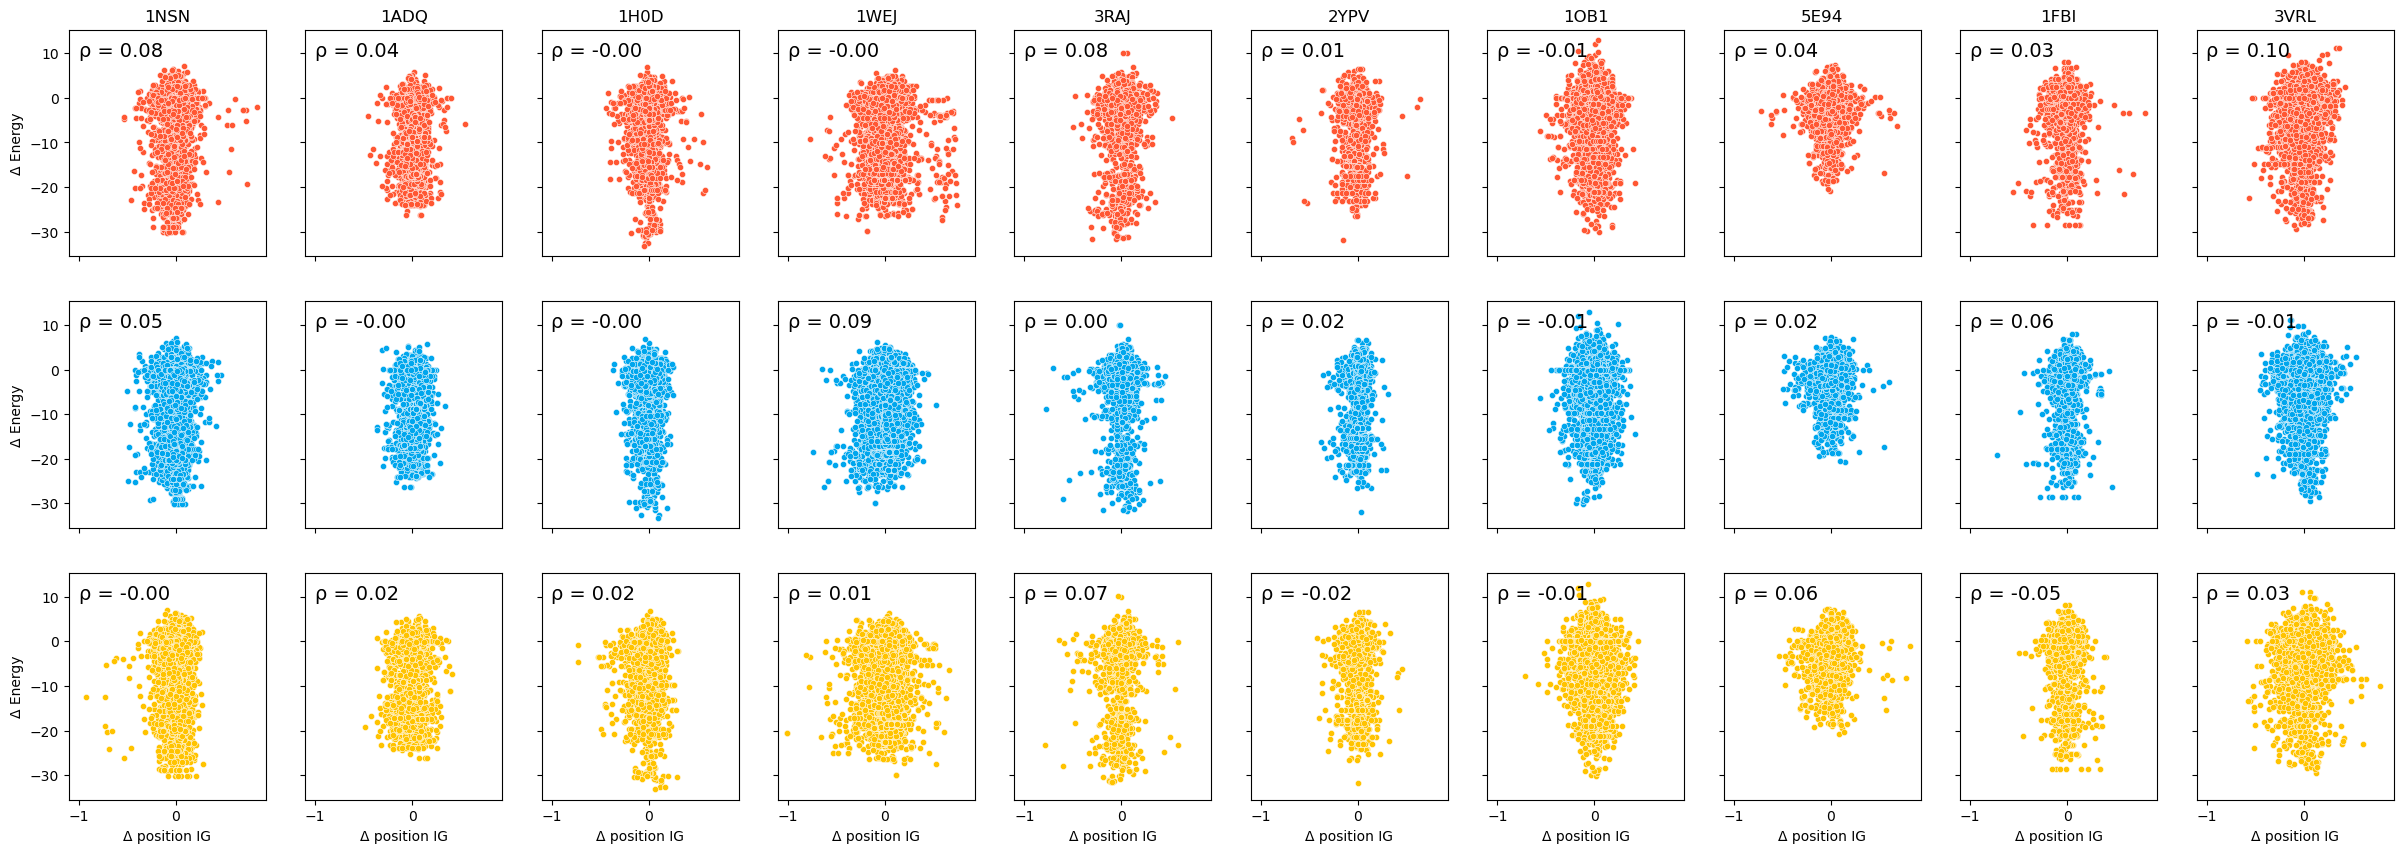

In [140]:
#shuffled
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_shuffled_mut_igs.csv')
        color = get_color(task)
        sns.scatterplot(mut_ig, x = 'posn delta IG', y='dEnergy', s=20, color=color, ax=ax[i,j])#hue='degree wt'
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}'.format(np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ position IG')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(ag)
fig.savefig('./figures/shuffled_mut_igs_eng.svg', dpi=600)


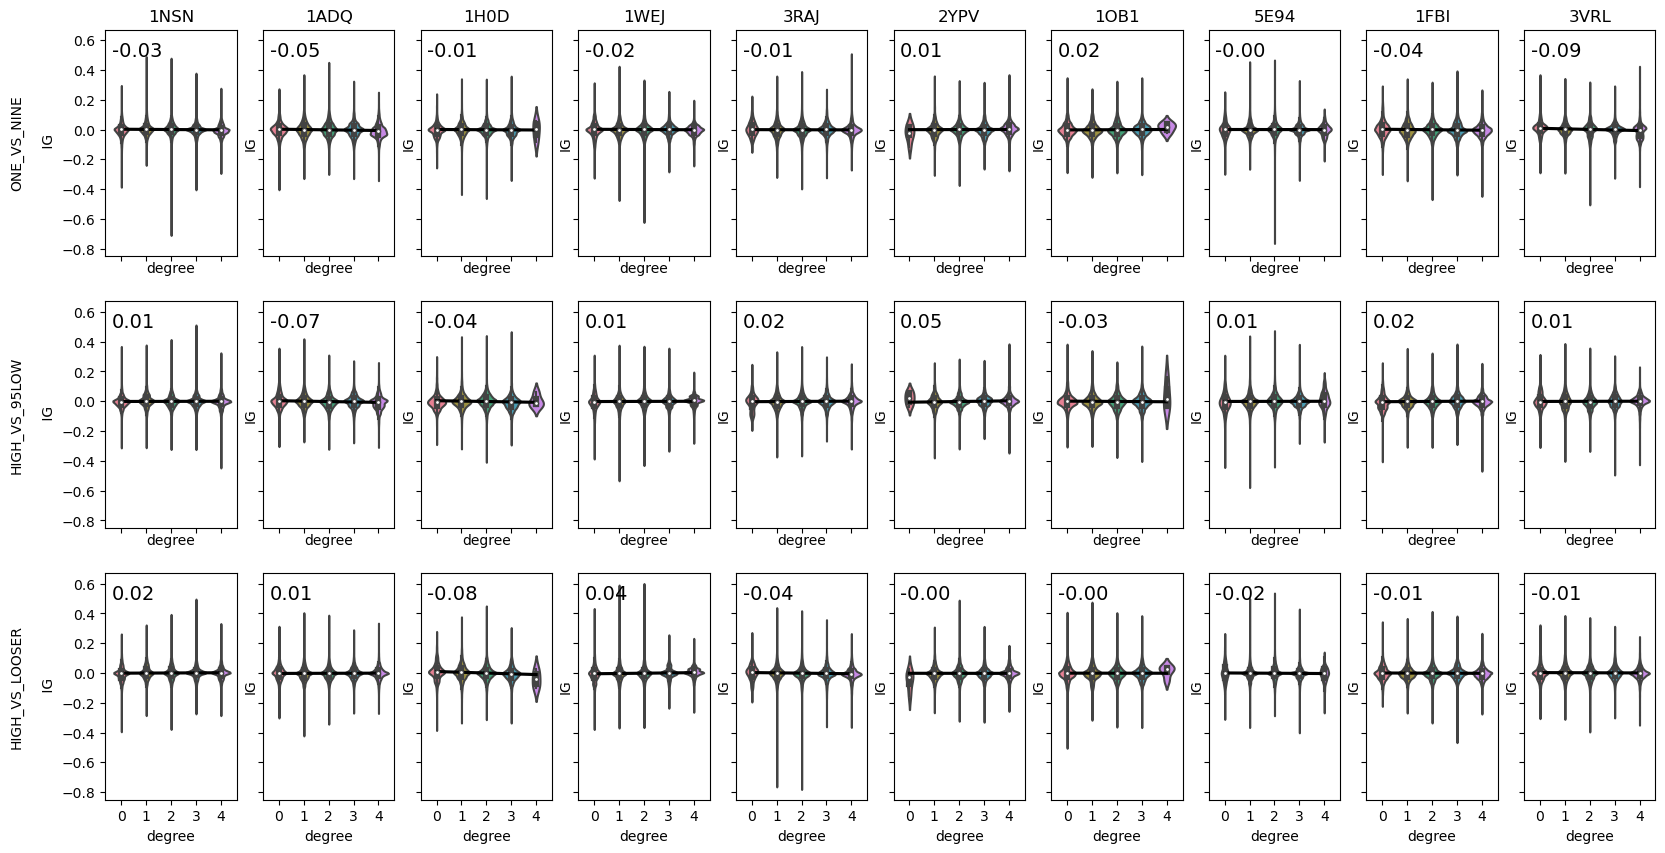

In [134]:
#shuffled
fig, ax = plt.subplots(3,10, sharex=True, sharey=True, figsize=(20,10))
for i, task in enumerate(tasks):
    for j, ag in enumerate(order_dict.keys()):
        #converters = {'IG': pd.eval, 'degrees': pd.eval}
        ig_df = pd.read_csv(f'./binder_igs/{ag}_{task}_shuffled_binder_igs.csv')
        ig_df['IG'] = ig_df['IG'].apply(eval)
        ig_df['degrees'] = ig_df['degrees'].apply(eval)
        # create df with ig and degree correspondance 
        igs = np.concatenate(ig_df['IG'].values).astype(float)
        degrees = np.concatenate(ig_df['degrees'].values).astype(int)
        df_degree_ig = pd.DataFrame.from_dict({'degree': degrees, 'IG': igs})

        r = i
        c = j
        sns.violinplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], palette='husl')
        sns.regplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], scatter=False, color='black')
        ax[r,c].text(0.05, 0.95, '{:.2f}'.format(np.corrcoef(df_degree_ig['degree'].values, df_degree_ig['IG'].values)[0,1]), transform=ax[r,c].transAxes, fontsize=14, verticalalignment='top')
        #title of sublots
        ax[0,c].set_title(ag)
    ax[r,0].set_ylabel(f'{task}\n\n IG')
plt.savefig('./figures/shuffled_mut_igs_degree.svg', dpi=600)

In [17]:
ag = '3VRL'
task = 'ONE_VS_NINE'
perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()

0.9757878939469736

In [18]:
task = 'ONE_VS_NINE'
order_dict = dict()
for j, ag in enumerate(config.ANTIGENS): 
    df_a = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
    order_dict[ag] = np.corrcoef(df_a['posn delta IG'].values, df_a['dEnergy'].values)[0,1]

    #df_a.groupby('ag')
   # ['posn delta IG'].values, mut_ig['dEnergy'].


In [19]:
order_dict.values()

dict_values([-0.6332871387503727, -0.0731364179506543, -0.3826729350872268, -0.5957854467971937, -0.2565438142125766, -0.3592023052612792, -0.19393809492531638, -0.6084262877631836, -0.40633993810267094, -0.5235755389593202])

In [20]:
order_dict = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1], reverse=True)}

In [21]:
order_dict.keys()

dict_keys(['1NSN', '1ADQ', '1H0D', '1WEJ', '3RAJ', '2YPV', '1OB1', '5E94', '1FBI', '3VRL'])

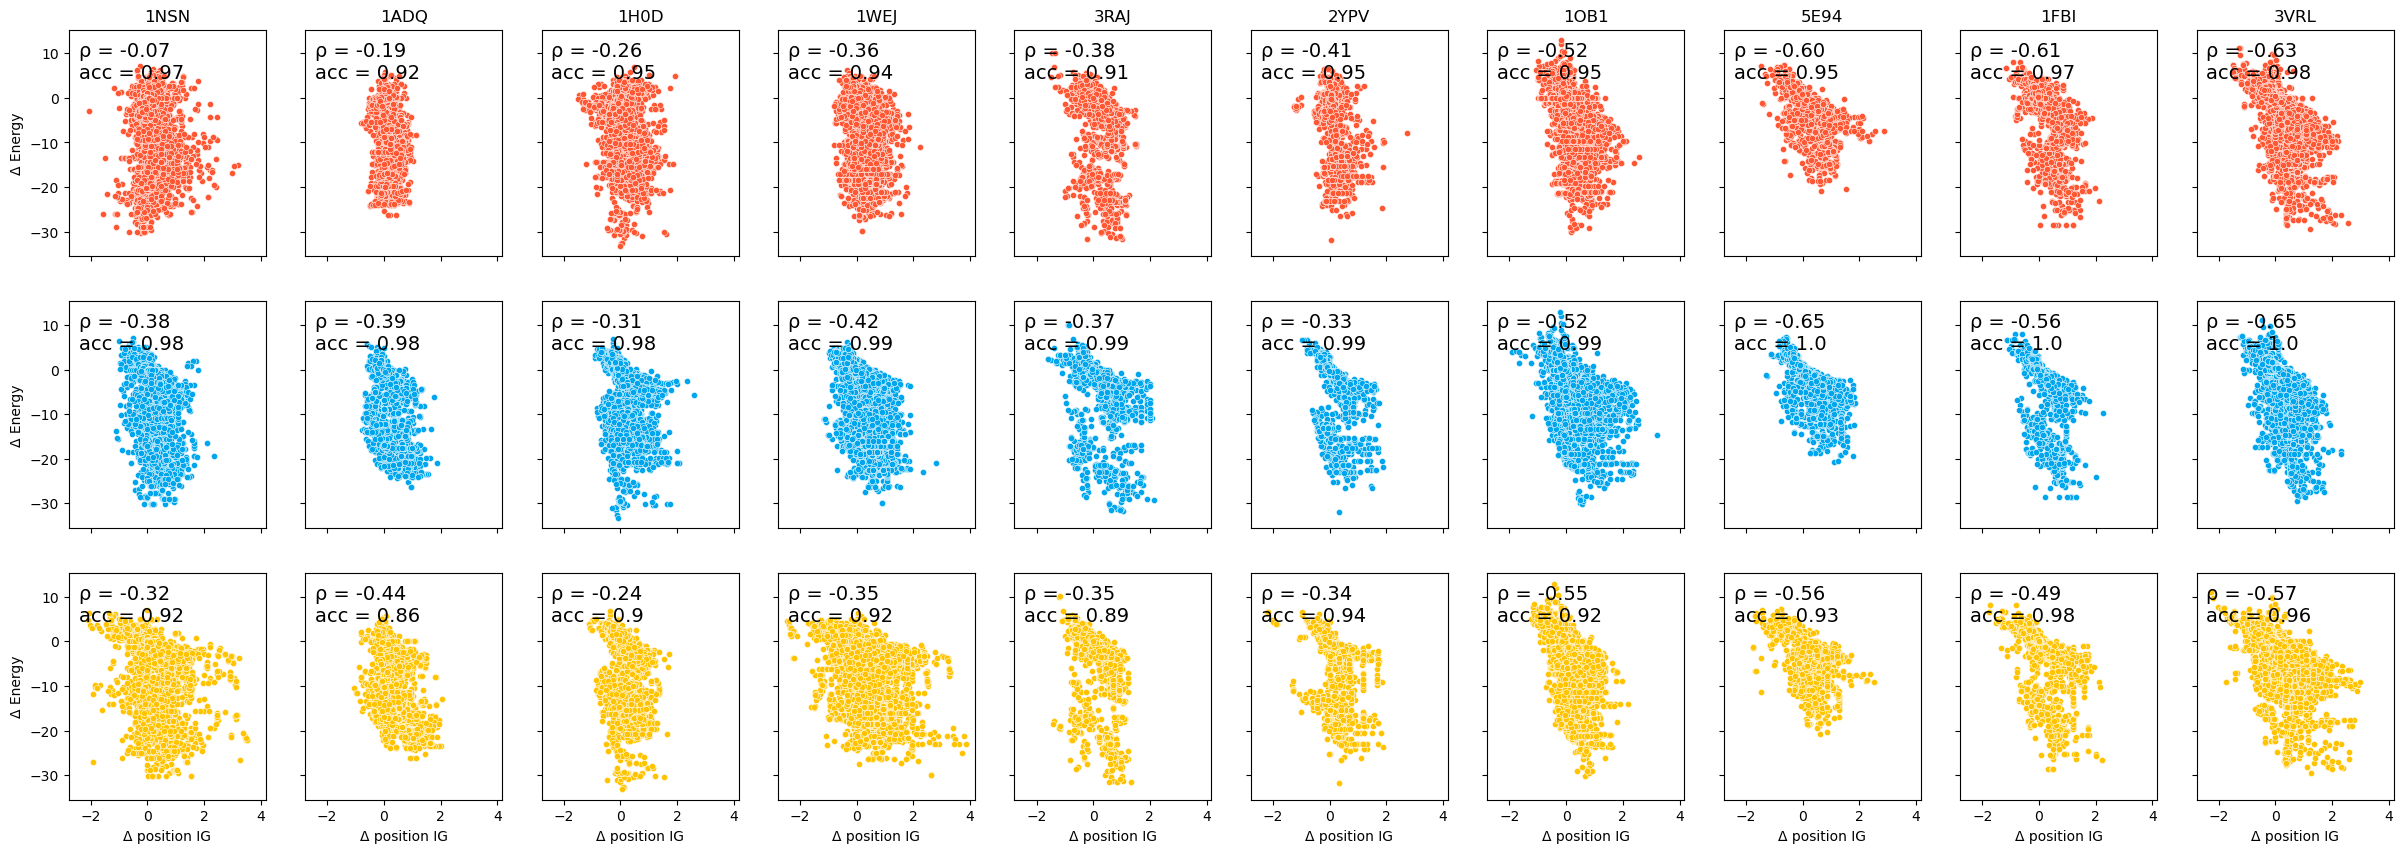

In [148]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        color = get_color(task)
        sns.scatterplot(mut_ig, x = 'posn delta IG', y='dEnergy', s=20, color=color, ax=ax[i,j])#linewidth=0.02
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}\nacc = {acc}'.format(np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1], acc=acc), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ position IG')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(ag)
fig.savefig('./figures/mut_igs_eng.svg')

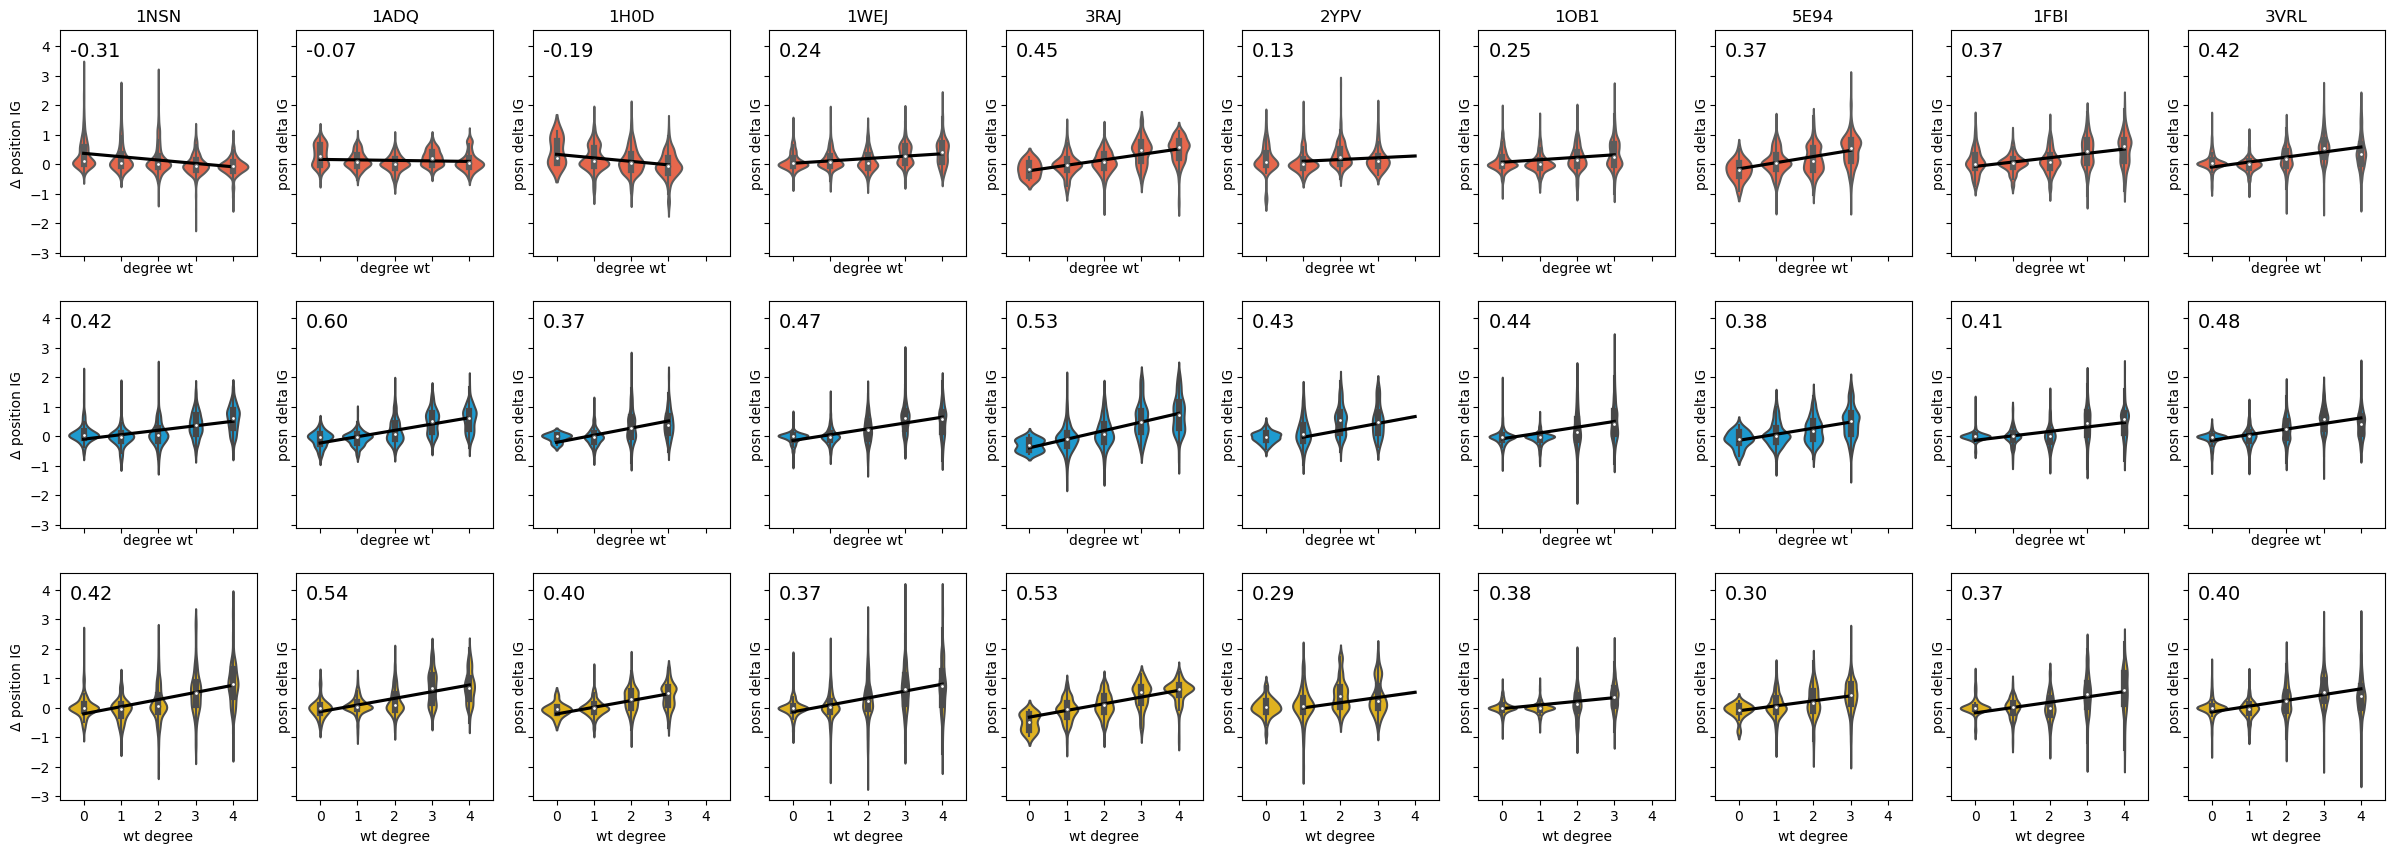

In [103]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        color = get_color(task)
        sns.violinplot(mut_ig, y = 'posn delta IG', x='degree wt', s=20, color=color, ax=ax[i,j])#hue='degree wt'
        sns.regplot(mut_ig, x='degree wt', y='posn delta IG', scatter=False, color='black', ax=ax[i,j])
        ax[i,j].text(0.05, 0.95, '{:.2f}'.format(np.corrcoef(mut_ig['degree wt'].values, mut_ig['posn delta IG'].values)[0,1]), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')

        #rename x-axis
        ax[2,j].set_xlabel('wt degree')
        #rename y-axis
        ax[i,0].set_ylabel('Δ position IG')
    ax[0,j].set_title(ag)


In [106]:
dfs = []
for ag in config.ANTIGENS:
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    pos_degree_df = pd.read_csv(path_epi, sep='\t')
    pos_degree_df['antigen'] = ag
    dfs.append(pos_degree_df)
all_ag_imp_df = pd.concat(dfs)
all_ag_imp_df['aa_degrees'] = all_ag_imp_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
all_ag_imp_df['degrees'] = all_ag_imp_df['aa_degrees'].apply(lambda d: list(map(lambda x: int(re.search('(\d)',x).group(1)),d)))

In [107]:
import warnings
warnings.filterwarnings("ignore")

In [109]:
order_dict.keys()

dict_keys(['1NSN', '1ADQ', '1H0D', '1WEJ', '3RAJ', '2YPV', '1OB1', '5E94', '1FBI', '3VRL'])

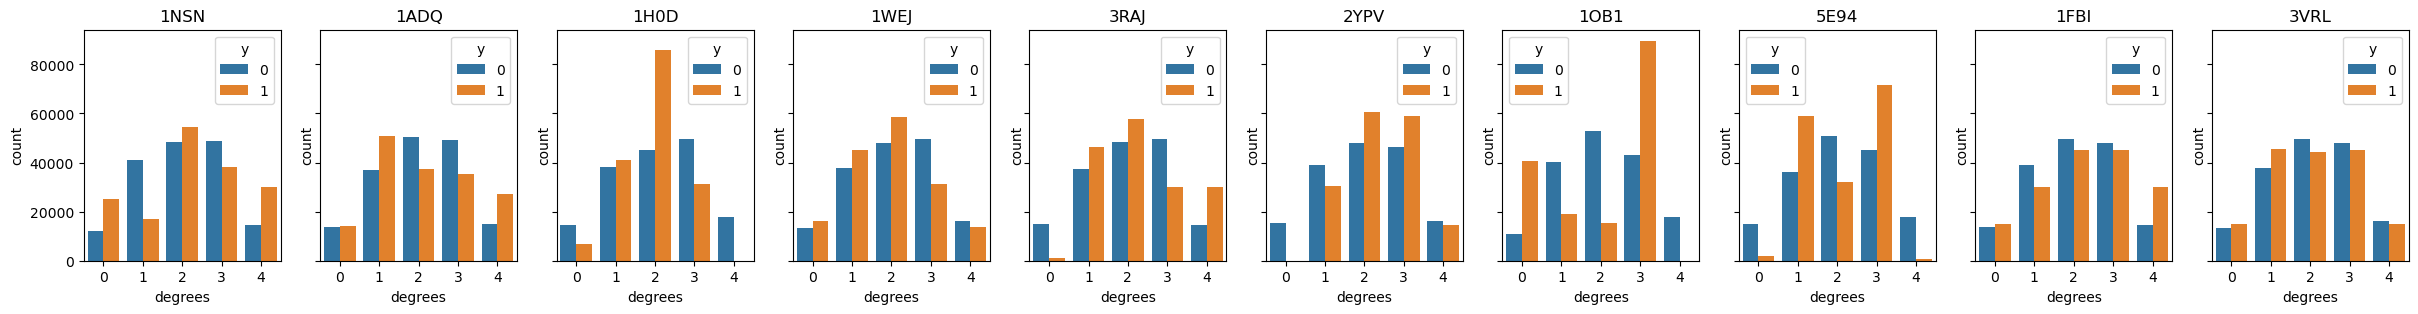

In [147]:
fig, ax = plt.subplots(1,10, sharex=True, sharey=True, figsize=(30,3))
task = 'ONE_VS_NINE'
for i, ag in enumerate(order_dict.keys()):
    seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/*_train_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
    train_df = pd.read_csv(wt_path, sep='\t')
    df_merged = all_ag_imp_df.merge(train_df, how='inner', on=['Slide'])
    ax[i].set_title(ag)
    sns.countplot(x='degrees', hue='y', data=df_merged.explode('degrees'), ax=ax[i])
    #ax[i].text(0.05, 0.95, f'pos_ag {len(df_merged[df_merged['y']==1])}, neg_ag {len(df_merged[df_merged['y']==0])}', transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
fig.savefig('./figures/aa_degrees_in_vs_all.svg')




In [86]:
#plor ro correlation with accurcy
acc_corr = []
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
        corr_c = np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]
        acc_corr.append([ag, task, acc, corr_c])
acc_corr = pd.DataFrame(acc_corr, columns=['ag', 'task', 'acc', 'corr_c'])
       

In [87]:
acc_corr = pd.DataFrame(acc_corr, columns=['ag', 'task', 'acc', 'corr_c'])

In [ ]:
    if task == 'ONE_VS_NINE' :
        color= '#FF5733'
    elif task == 'HIGH_VS_95LOW':
        
        color = '#00A6ED'
    else:
        color = '#FFC300'
    return color

Text(0, 0.5, 'Prediction accuracy')

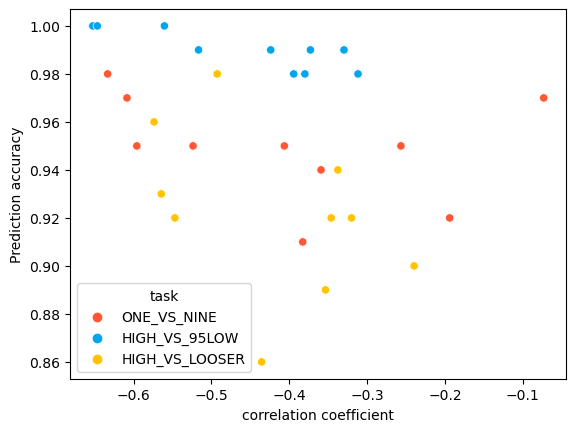

In [149]:
sns.scatterplot(x=corrs, y=accs, data=acc_corr, hue='task', palette=['#FF5733', '#00A6ED', '#FFC300'])
plt.xlabel('correlation coefficient')
plt.ylabel('Prediction accuracy')

In [62]:
# for 1 vs 1
for pos_ag in tqdm(config.ANTIGENS, desc='pos_ag'):
    seed_id = 0
    split_id = 0
    neg_ags = [x for x in config.ANTIGENS if x != pos_ag]
    mut_file = prep_mut_df(pos_ag)
    path_epi = glob.glob(f'../data/Slide_importance/{pos_ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    for neg_ag in tqdm(neg_ags, desc='neg_ag'):
        wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_{seed_id}/split_{split_id}/{pos_ag}__vs__{neg_ag}/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
        slide_id_df = get_org_slide_id(mut_file, wt_path)
        #getting aa degrees
        slide_id_df= slide_id_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
        try:
            slide_id_df['aa_degrees'] = slide_id_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
            slide_id_df.drop('seqABParatope', axis=1, inplace=True)

            ag_vs_one_path = f"./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_{seed_id}/split_{split_id}/{pos_ag}__vs__{neg_ag}"               
            model_path = f"{ag_vs_one_path}/swa_model/data/model.pth"
            model = torch.load(model_path, map_location=torch.device('cpu'))
            ig = IntegratedGradients(model.cpu())
            mut_igs = mutant_ig(ig,mut_file, slide_id_df)
            mut_igs.to_csv(f'./mutant_igs/{pos_ag}__vs__{neg_ag}_mut_igs.csv', index=False)
        except:
            pass

pos_ag: 100%|██████████| 10/10 [19:42<00:00, 118.25s/it]


In [76]:
df_1vs1_ig_energy = []
for i, pos_ag in enumerate(config.ANTIGENS):
    neg_ags = [x for x in config.ANTIGENS if x != pos_ag]
    for j, neg_ag in enumerate(neg_ags):
        mut_ig = pd.read_csv(f'./mutant_igs/{pos_ag}__vs__{neg_ag}_mut_igs.csv')
        corr_c = np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]
        corr_c = round(corr_c,2)
        df_1vs1_ig_energy.append([pos_ag, neg_ag, corr_c])
df_1vs1_ig_energy = pd.DataFrame(df_1vs1_ig_energy, columns=['pos_ag', 'neg_ag', 'corr_c'])


Text(50.722222222222214, 0.5, 'positive antigen')

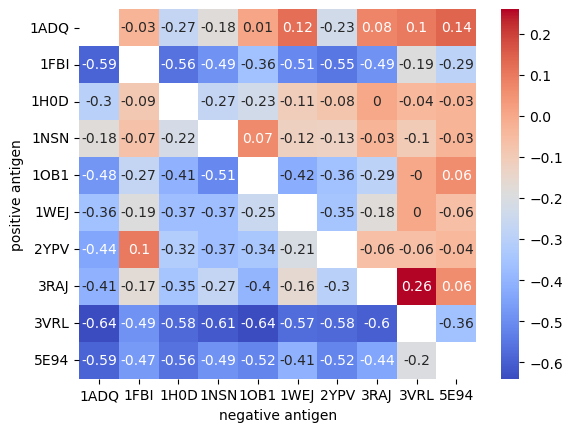

In [80]:
sns.heatmap(df_1vs1_ig_energy.pivot(index='pos_ag', columns='neg_ag', values='corr_c'), annot=True, cmap='coolwarm')
plt.xlabel('negative antigen')
plt.ylabel('positive antigen')
#will be good to correlate with accuracy

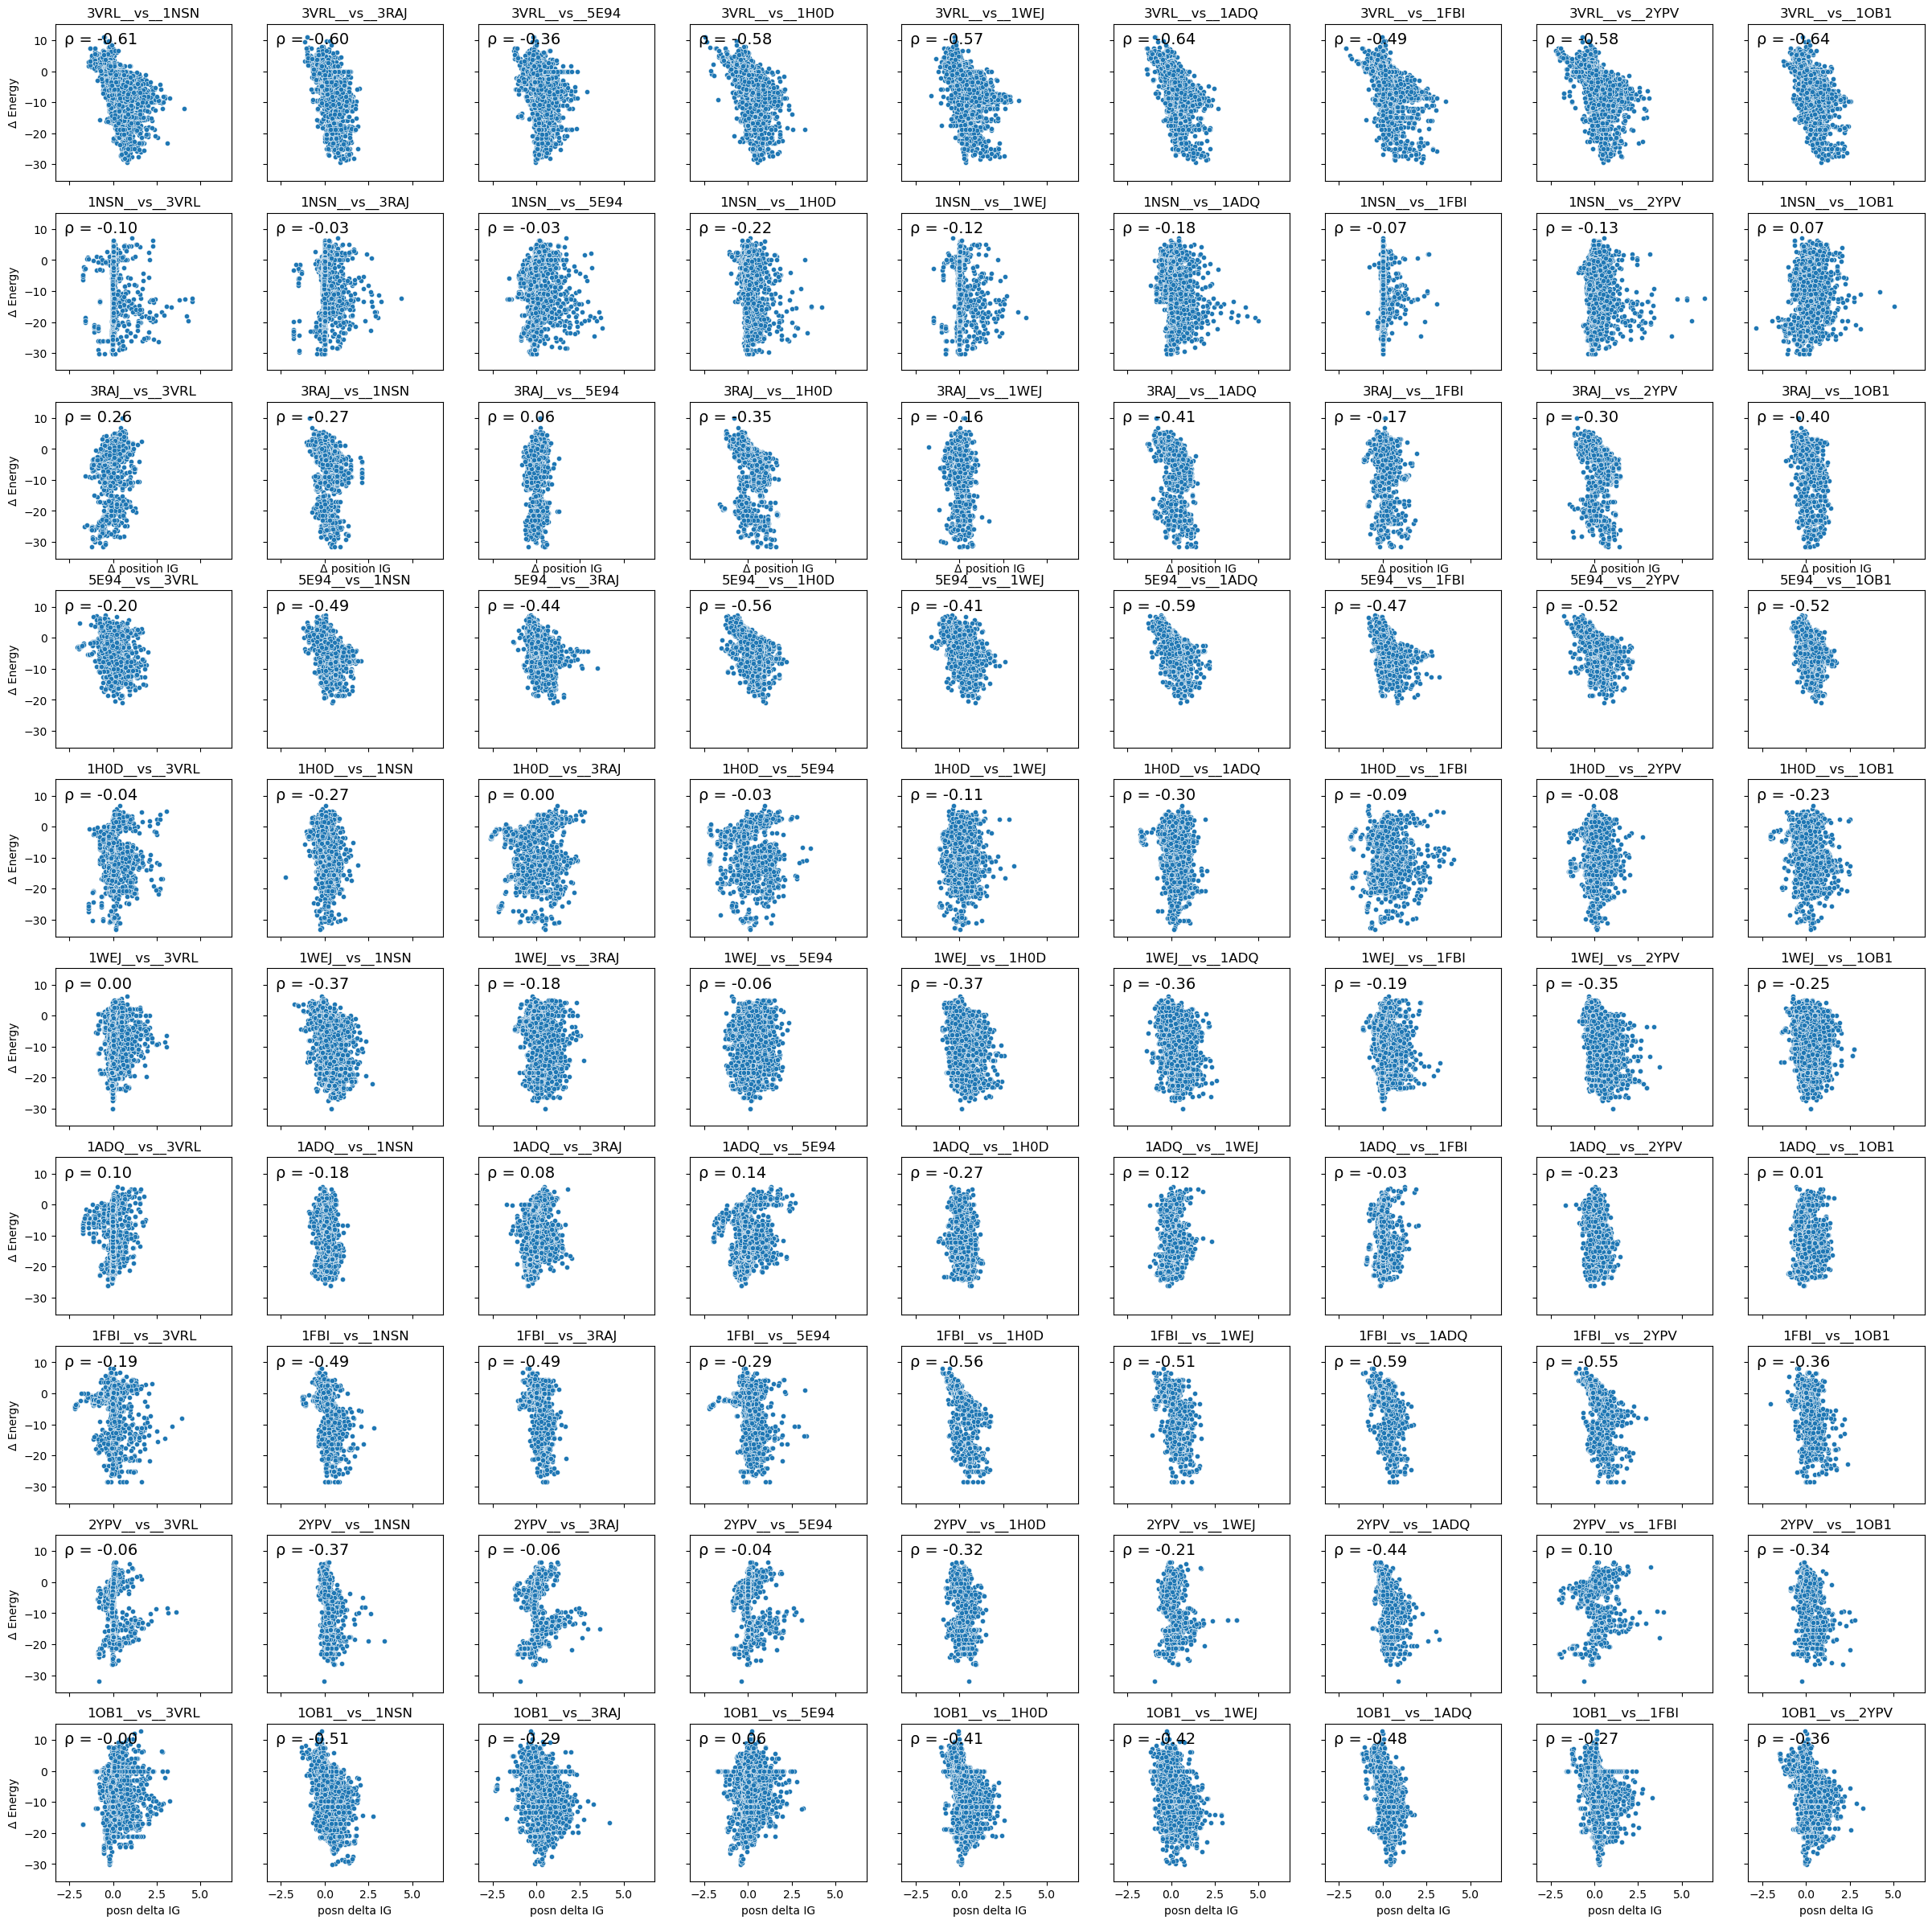

In [66]:
fig, ax = plt.subplots(10,9, figsize=(30,30),sharex=True, sharey=True)
for i, pos_ag in enumerate(config.ANTIGENS):
    neg_ags = [x for x in config.ANTIGENS if x != pos_ag]
    for j, neg_ag in enumerate(neg_ags):
        mut_ig = pd.read_csv(f'./mutant_igs/{pos_ag}__vs__{neg_ag}_mut_igs.csv')
        sns.scatterplot(mut_ig, x = 'posn delta IG', y='dEnergy', s=20, ax=ax[i,j])#hue='degree wt'
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}'.format(np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ position IG')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
        ax[i,j].set_title(f'{pos_ag}__vs__{neg_ag}')

## Calculating IG for all test sequences

In [56]:
for ag in config.ANTIGENS:
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0]
    wt_df = pd.read_csv(wt_path, sep='\t')
    binder_df = wt_df[wt_df['y'] == 1]
    binder_df['X'] = binder_df.Slide.apply(onehot_encode)
    # get degree of each slide
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    binder_df= binder_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
    binder_df['aa_degrees'] = binder_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    binder_df['degrees'] = binder_df['aa_degrees'].apply(lambda d: list(map(lambda x: int(re.search('(\d)',x).group(1)),d)))
    binder_df.drop('seqABParatope', axis=1, inplace=True)

    for task in tasks:
        seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        binder_df['IG'] = binder_df.X.apply(lambda x: ig_from_oh(x,ig,baseline))
        binder_df.to_csv(f'./binder_igs/{ag}_{task}_binder_igs.csv', index=False)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_77727/210821106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binder_df['X'] = binder_df.Slide.apply(onehot_encode)
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_77727/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_77727/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_77

In [57]:
task = 'ONE_VS_NINE'
order_dict = dict()
for ag in config.ANTIGENS:
    ig_df = pd.read_csv(f'./binder_igs/{ag}_{task}_binder_igs.csv')
    ig_df['IG'] = ig_df['IG'].apply(eval)
    ig_df['degrees'] = ig_df['degrees'].apply(eval)
        # create df with ig and degree correspondance 
    igs = np.concatenate(ig_df['IG'].values).astype(float)
    degrees = np.concatenate(ig_df['degrees'].values).astype(int)
    df_degree_ig = pd.DataFrame.from_dict({'degree': degrees, 'IG': igs})
    order_dict[ag] = np.corrcoef(df_degree_ig['degree'].values, df_degree_ig['IG'].values)[0,1]

In [58]:
order_dict
order_dict = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1])}

In [59]:
order_dict

{'1NSN': -0.4423994789235985,
 '1H0D': -0.28370929649712934,
 '1ADQ': -0.0032288779708532053,
 '2YPV': 0.032518100719305006,
 '1WEJ': 0.1257234742535492,
 '1OB1': 0.19204966473114404,
 '1FBI': 0.2765363323910073,
 '5E94': 0.46500462982794616,
 '3VRL': 0.48316998231615477,
 '3RAJ': 0.5679816212601967}

In [45]:
order_dict

{'1NSN': -0.4423994789235985,
 '1H0D': -0.28370929649712934,
 '1ADQ': -0.0032288779708532053,
 '2YPV': 0.032518100719305006,
 '1WEJ': 0.1257234742535492,
 '1OB1': 0.19204966473114404,
 '1FBI': 0.2765363323910073,
 '5E94': 0.46500462982794616,
 '3VRL': 0.48316998231615477,
 '3RAJ': 0.5679816212601967}

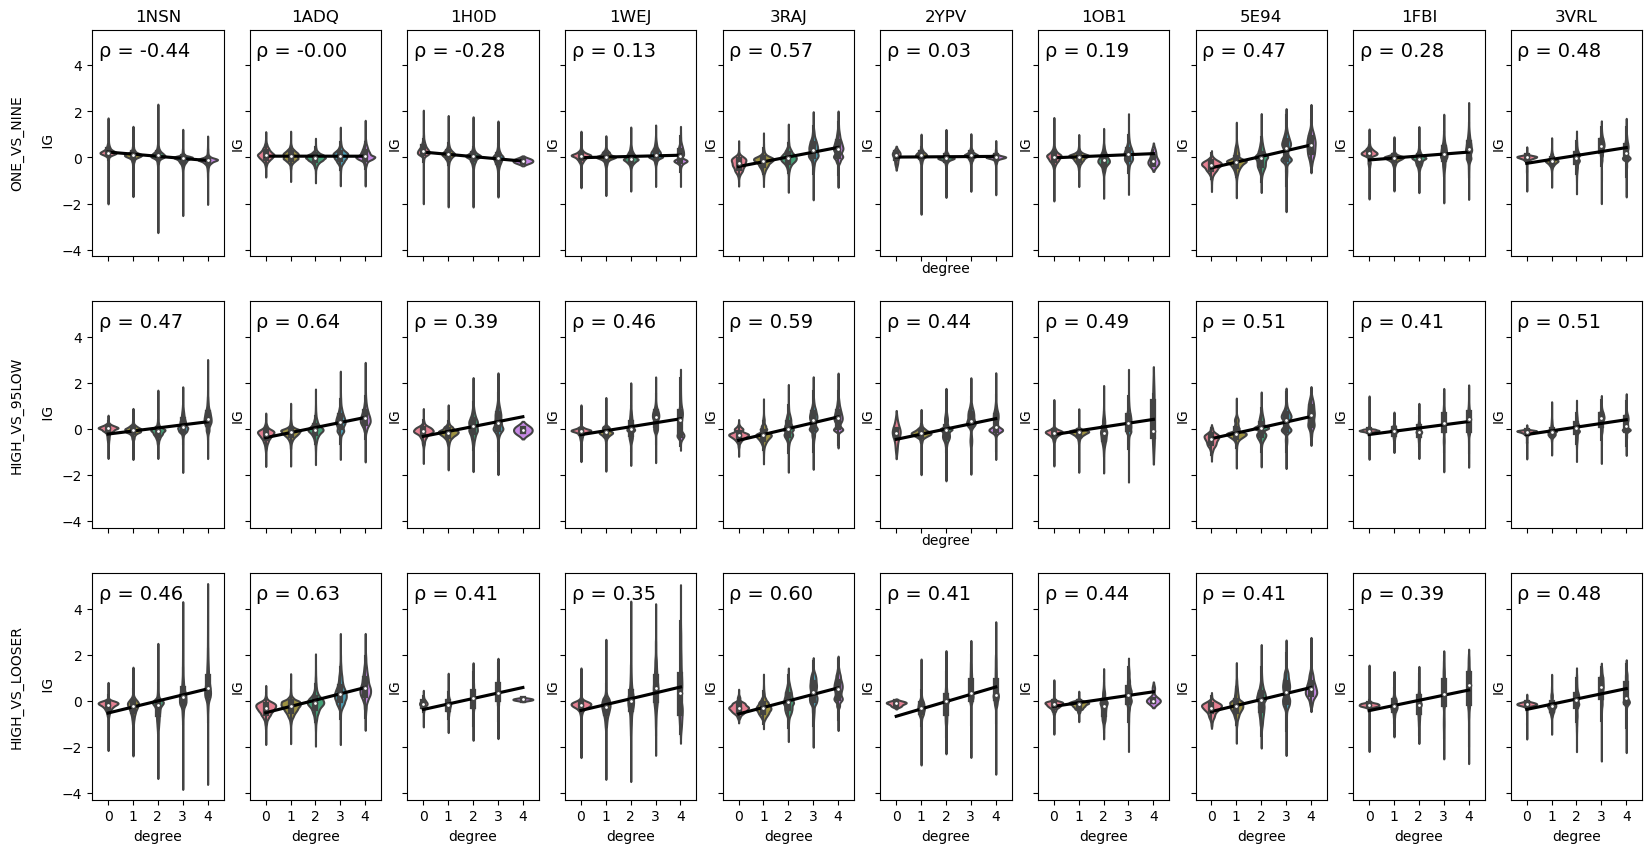

In [143]:
fig, ax = plt.subplots(3,10, sharex=True, sharey=True, figsize=(20,10))
for i, task in enumerate(tasks):
    for j, ag in enumerate(order_dict.keys()):
        #converters = {'IG': pd.eval, 'degrees': pd.eval}
        ig_df = pd.read_csv(f'./binder_igs/{ag}_{task}_binder_igs.csv')
        ig_df['IG'] = ig_df['IG'].apply(eval)
        ig_df['degrees'] = ig_df['degrees'].apply(eval)
        # create df with ig and degree correspondance 
        igs = np.concatenate(ig_df['IG'].values).astype(float)
        degrees = np.concatenate(ig_df['degrees'].values).astype(int)
        df_degree_ig = pd.DataFrame.from_dict({'degree': degrees, 'IG': igs})

        r = i
        c = j
        sns.violinplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], palette='husl')
        sns.regplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], scatter=False, color='black')
        ax[r,c].text(0.05, 0.95, 'ρ = {:.2f}'.format(np.corrcoef(df_degree_ig['degree'].values, df_degree_ig['IG'].values)[0,1]), transform=ax[r,c].transAxes, fontsize=14, verticalalignment='top')
        #remove x-axis label except last row
        if (r != 2) and (c != 5):
            ax[r,c].set_xlabel('')
        #despine sns.despine()
        #title of sublots
        ax[0,c].set_title(ag)
    ax[r,0].set_ylabel(f'{task}\n\n IG')
fig.savefig('./figures/mut_igs_degree.svg', dpi=600)


In [84]:
seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
train_data_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/*_train_dataset.tsv')[0]
train_df = pd.read_csv(train_data_path, sep='\t')
path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
para_epi = pd.read_csv(path_epi, sep='\t')
train_df= train_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
train_df['aa_degrees'] = train_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
train_df.drop('seqABParatope', axis=1, inplace=True)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


TypeError: 'float' object is not subscriptable

In [82]:
#loose
pd.read_csv(train_data_path, sep='\t').head()

,Slide,binds_a_pos_ag,Slide_onehot,X,y
0,AAAVLLRYLYY,1,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
1,AAFITTVVARF,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
2,AAFYGNLAWFA,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
3,AAFYYDYPAWF,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
4,AAGLLLAWFAY,1,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
